In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import numpy as np
import statsmodels.tsa.api as sm
import warnings
warnings.filterwarnings('ignore')
sns.set()

### Loading the base dataset

In [44]:
def tsplot(y, lags=50, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))    
        y.plot(ax=ts_ax)
        p_value = sm.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return

In [86]:
df = pd.read_excel("Data/NEER_Economic_Indicators.xlsx")
df.head()

,date,neer,cpi_adjusted,export_price_index,import_price_index
0,2021-01-11,114.565,90.214,111.960,113.030
1,2021-02-11,114.870,90.261,113.635,115.507
2,2021-03-11,114.925,90.341,115.333,116.868
3,2021-04-11,115.808,91.316,116.138,117.220
4,2021-05-11,116.310,91.182,113.871,115.186


## Time series Analysis (Original)

### NEER

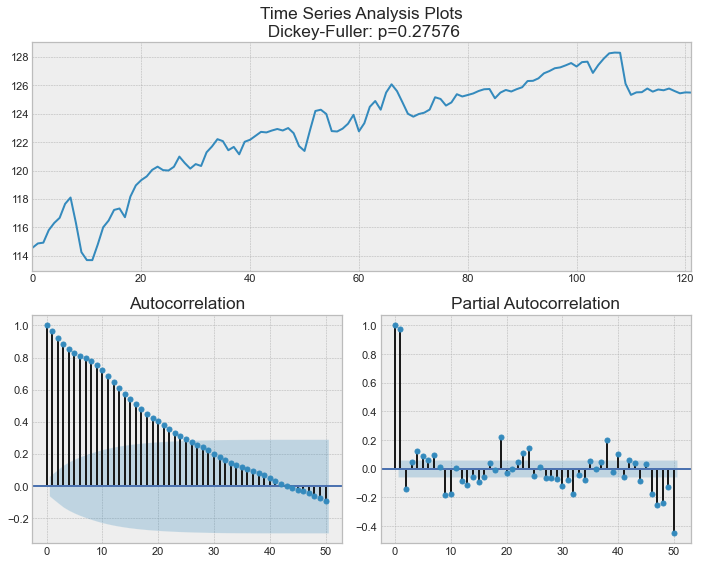

In [46]:
tsplot(df["neer"])

### CPI Adjusted

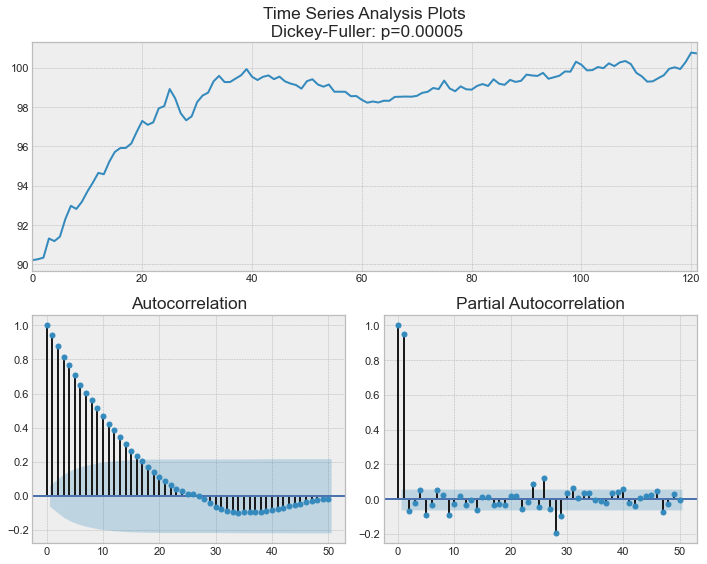

In [47]:
tsplot(df["cpi_adjusted"])

### Export Price Index

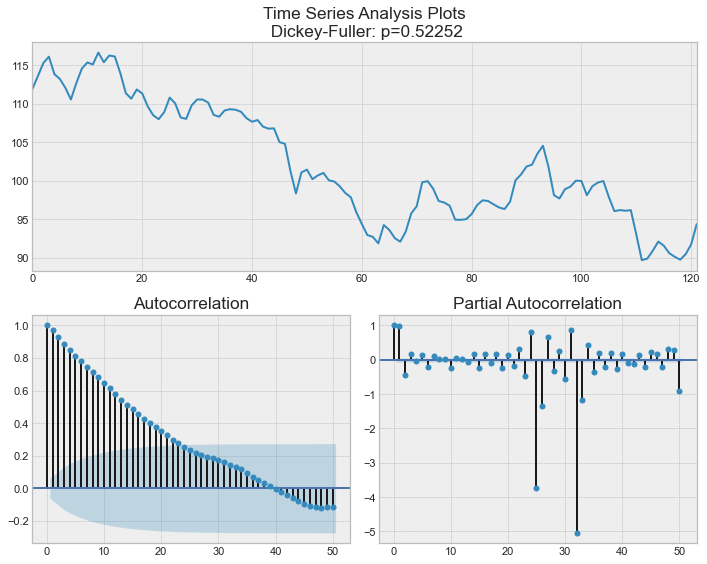

In [48]:
tsplot(df["export_price_index"])

### Import Price Index

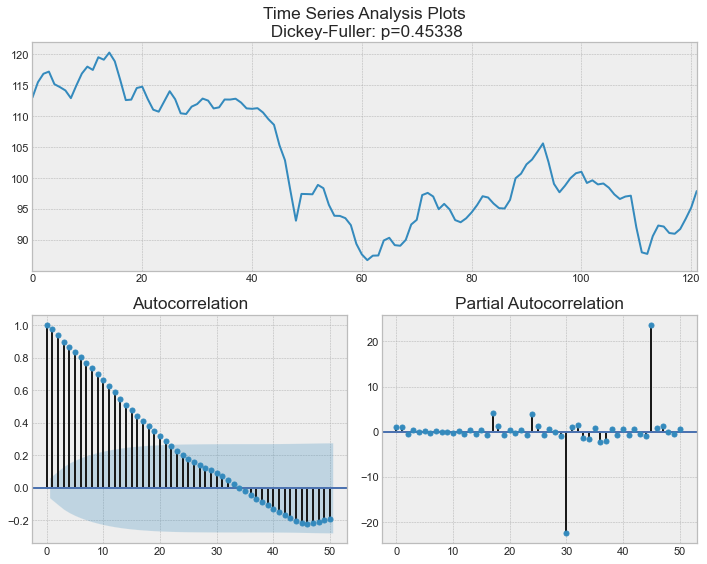

In [49]:
tsplot(df["import_price_index"])

## Time Series Analysis (Log Transformation)

In [50]:
focused_columns = ['neer', 'cpi_adjusted', 'export_price_index', 'import_price_index']
for column in focused_columns:
    if column in df.columns.values.tolist():
        df[column] = np.log(df[column]+1) 

### NEER (Log)

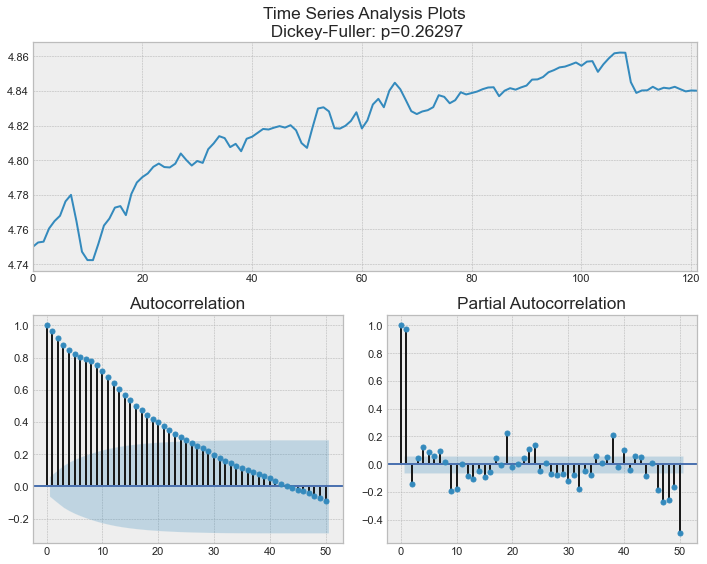

In [51]:
tsplot(df["neer"])

### CPI Adjusted (Log)

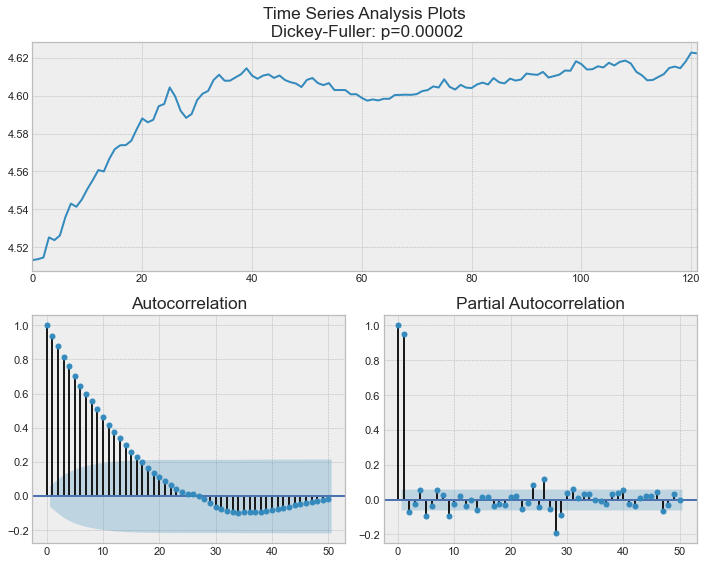

In [52]:
tsplot(df["cpi_adjusted"])

### Export Price Index (Log)

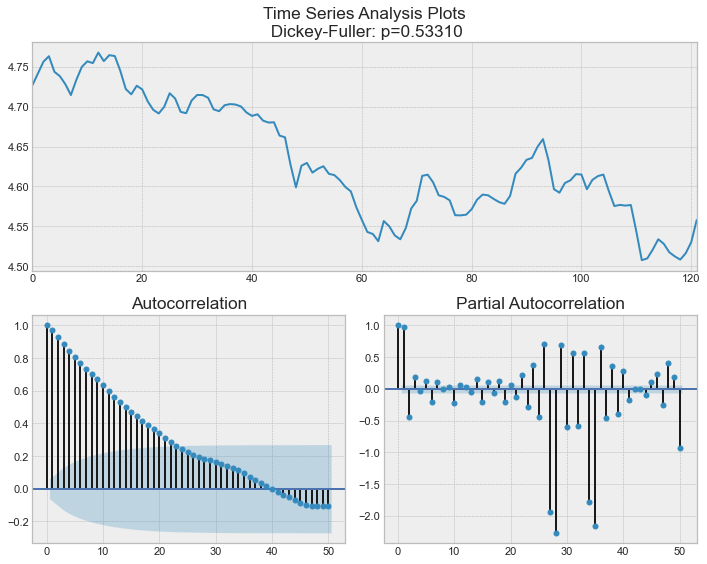

In [53]:
tsplot(df["export_price_index"])

### Import Price Index (Log)


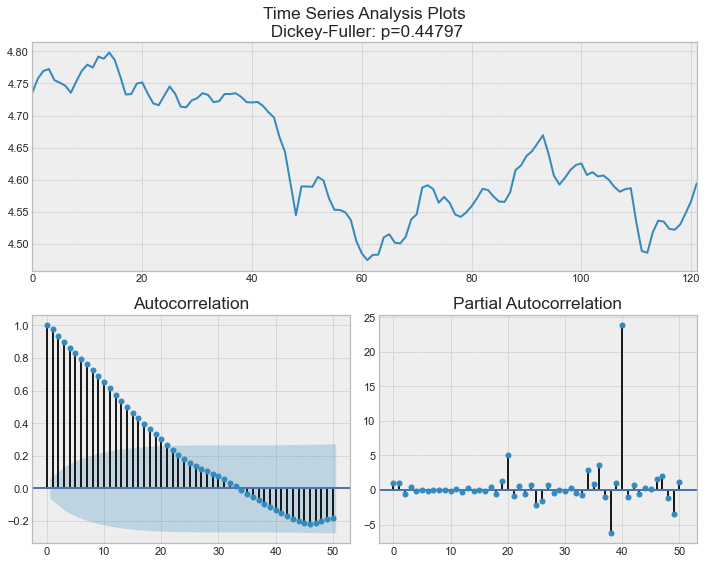

In [54]:
tsplot(df["import_price_index"])

## Differencing

In [55]:
focused_columns_diff = ['neer', 'export_price_index', 'import_price_index']
for column in focused_columns_diff:
    if column in df.columns.values.tolist():
        df[column] = df[column].diff().dropna()

In [56]:
df = df.dropna()
df.head()

,date,neer,cpi_adjusted,export_price_index,import_price_index
1,2021-02-11,0.002636,4.513724,0.014719,0.021490
2,2021-03-11,0.000475,4.514600,0.014704,0.011614
3,2021-04-11,0.007588,4.525217,0.006896,0.002982
4,2021-05-11,0.004288,4.523765,-0.019543,-0.017355
5,2021-06-11,0.003085,4.526214,-0.005535,-0.004062


###  NEER (Log + Diff)

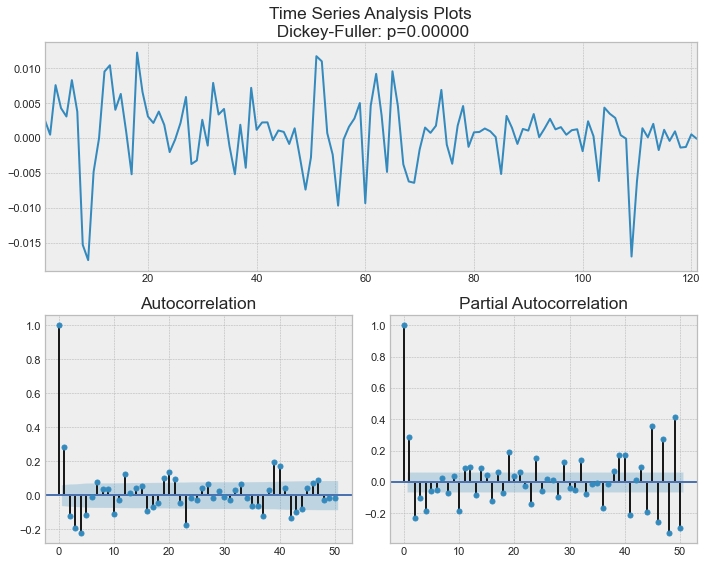

In [57]:
tsplot(df["neer"])

### Export Price Index (Log + Diff)

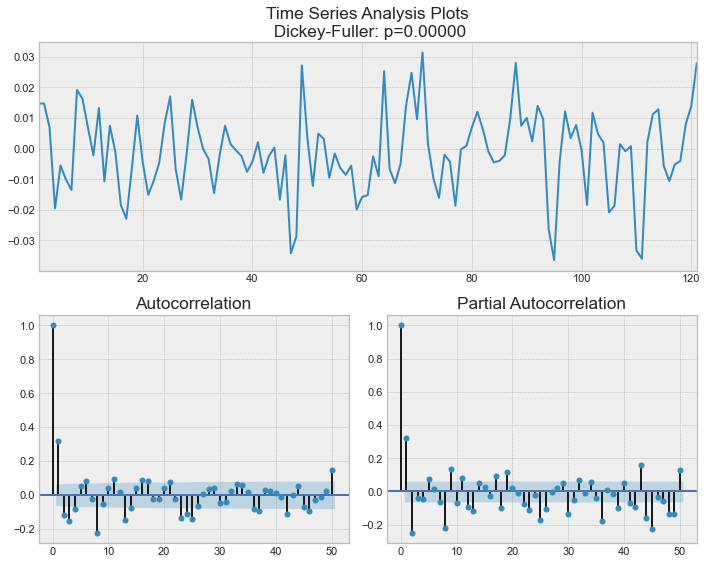

In [60]:
tsplot(df["export_price_index"])

### Import Price Index (Log + Diff)

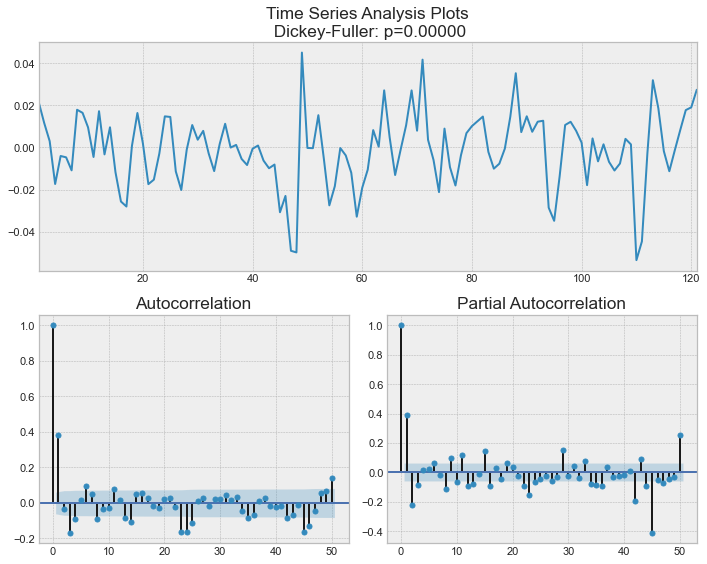

In [61]:
tsplot(df["import_price_index"])

## Var Model Set Up

In [62]:
model = VAR(df[focused_columns])
print(model.select_order(10).summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -38.19      -38.09   2.598e-17      -38.15
1      -41.49*     -41.00*  9.563e-19*     -41.29*
2       -41.44      -40.56   1.007e-18      -41.08
3       -41.35      -40.08   1.111e-18      -40.83
4       -41.28      -39.62   1.189e-18      -40.61
5       -41.08      -39.03   1.467e-18      -40.25
6       -40.95      -38.51   1.698e-18      -39.96
7       -40.72      -37.88   2.181e-18      -39.57
8       -40.65      -37.43   2.384e-18      -39.34
9       -40.48      -36.86   2.934e-18      -39.01
10      -40.70      -36.70   2.442e-18      -39.08
--------------------------------------------------


In [63]:
def write_results(file_name, results, columns):
    with open(file_name,"w") as fw:
        print(results.summary(), file=fw)
        fw.write("================test_whiteness================\n")
        print(results.test_whiteness(), file=fw)
        fw.write("================results.roots()================\n")
        for root in results.roots:
            fw.write(str(root)+",")
        fw.write("\n================is_stable================\n")
        fw.write(str(results.is_stable()))
        fw.write("\n================granger causality================\n")
        for V1 in columns:
            for V2 in columns:
                fw.write("Granger test: "+V2+"-->"+V1+"\n")
                print(results.test_causality(V1, [V2],kind='f').summary(), file=fw)
                fw.write("\n")

        fw.write("\n================long_run effects================\n")
        for effect in results.long_run_effects():
            fw.write(str(effect)+",")
        fw.write("\n================FEVD values================\n")
        print(results.fevd(20).summary,file=fw)

def structural_analyses(file_name, results, lag=20):

    # impulse response analyses
    irf = results.irf(lag)
    fig1 = irf.plot(orth=False)
    plt.savefig(file_name+"_irf_noorth.png")
    # irf.plot(impulse='V1', response="V2")
    fig2 = irf.plot_cum_effects(orth=False)
    plt.savefig(file_name+"_irf_cum_noorth.png")
    results.long_run_effects()

    col = sns.color_palette("hls", 11)
    # forecast error decomposition
    results.fevd(lag).plot()
    plt.savefig(file_name+"_fevd.png")
    fig1.set_figheight(20)
    fig1.set_figwidth(25)
    fig2.set_figheight(20)
    fig2.set_figwidth(25)

In [64]:
orders = [1]
for o in orders:
    print(f'Order: {o}')
    results = model.fit(o)
    print(results.is_stable())
    print(results.test_whiteness())
    print()


Order: 1
True
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: fail to reject at 5% significance level. Test statistic: 156.104, critical value: 173.004>, p-value: 0.232>



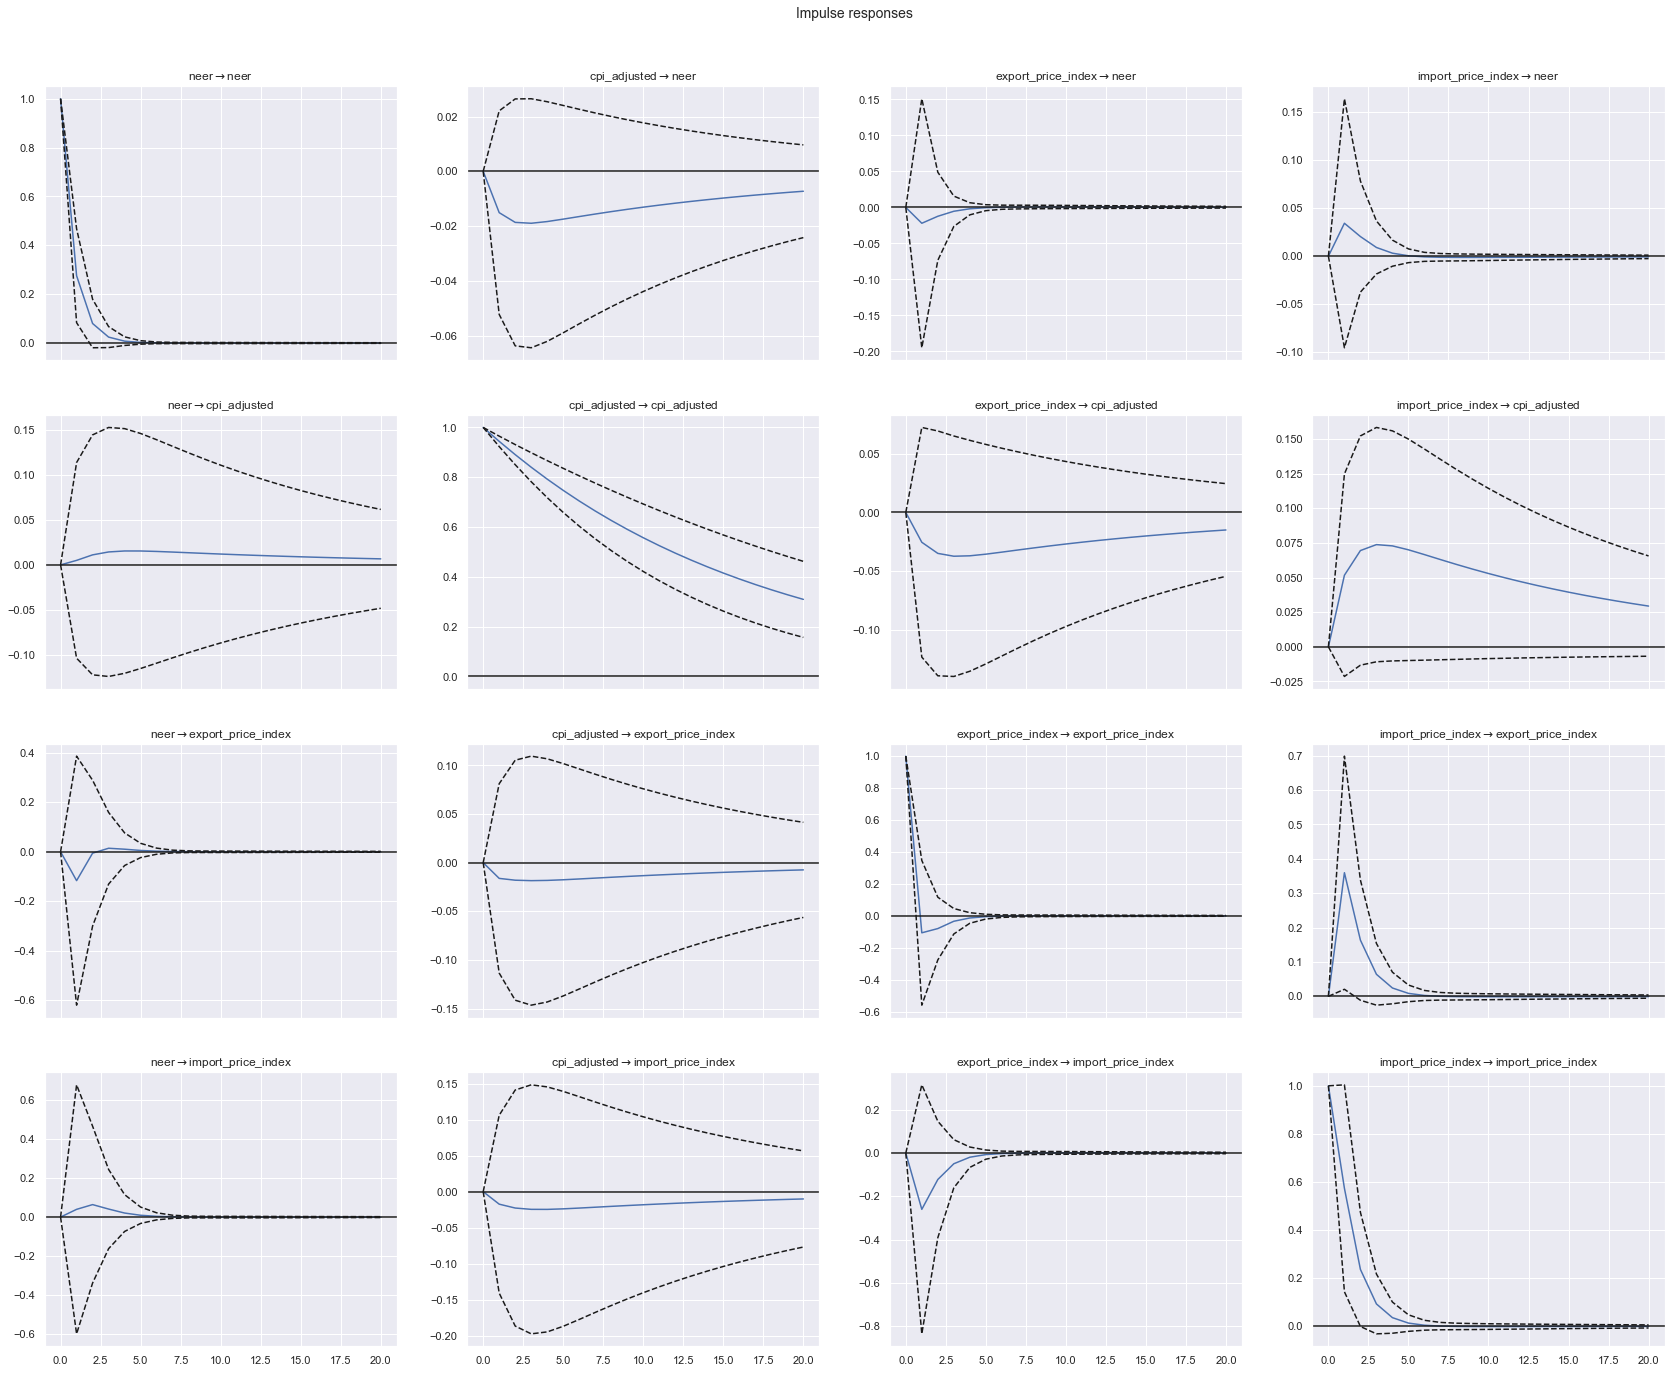

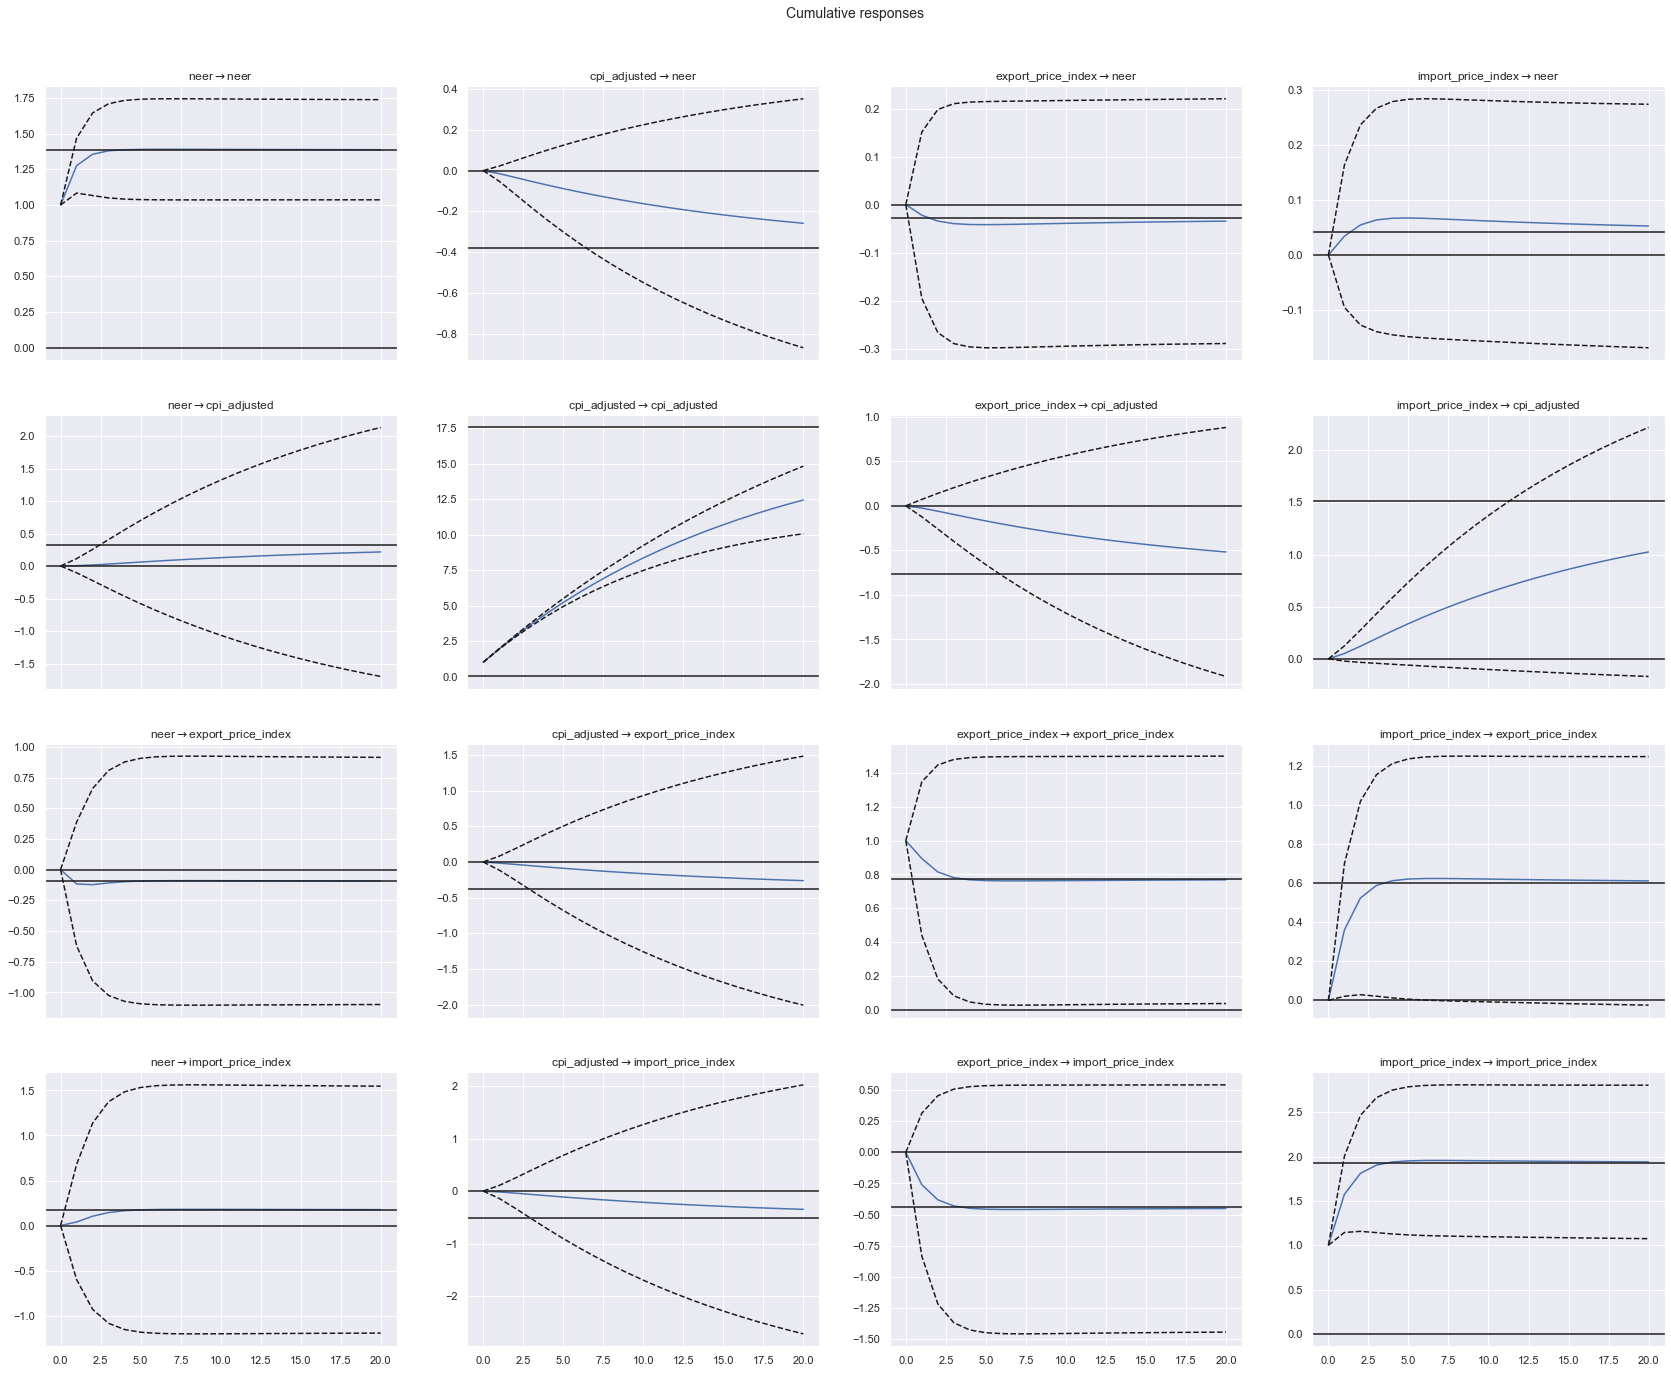

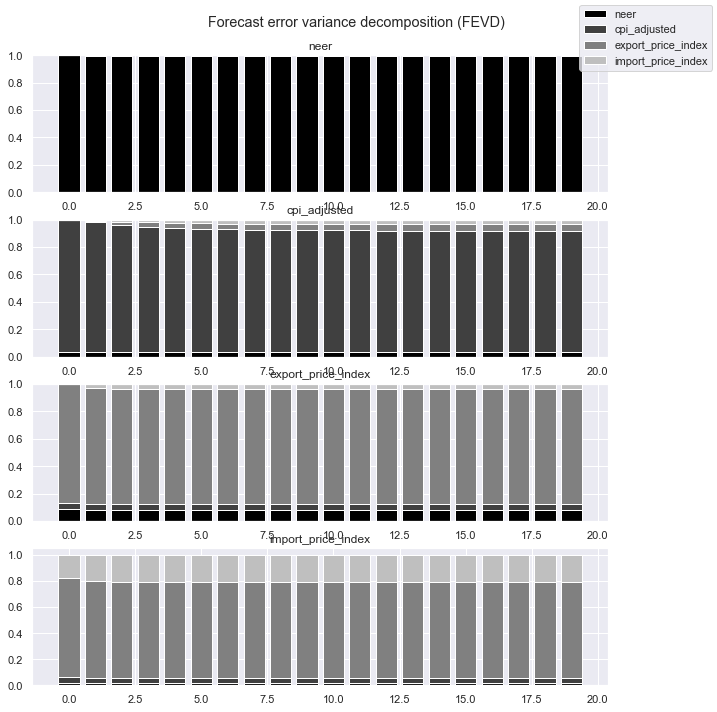

In [65]:
selected_order = 1
results = model.fit(selected_order,trend="c")
results_file = 'results_lag'+str(selected_order)+'.txt'
structual_file = 'lag'+str(selected_order)
columns = df[focused_columns].columns.values.tolist()
write_results(results_file, results, columns)
structural_analyses(structual_file, results, 20)

### Drilling down to specific merchandise import categories

In [68]:
df_imports = pd.read_excel("Data/import_PI.xlsx")
df_imports.head()

,date,neer,import_price_index_food&animals,import_price_index_manufacturedgoods,import_price_index_machinery,import_price_index_crudematerials
0,2021-01-11,114.565,100.239,109.882,108.751,127.989
1,2021-02-11,114.870,100.988,111.629,108.750,133.227
2,2021-03-11,114.925,100.879,111.632,108.286,126.073
3,2021-04-11,115.808,101.632,111.715,106.711,130.438
4,2021-05-11,116.310,101.383,110.643,106.170,127.293


### Food & Animals Import Price Index

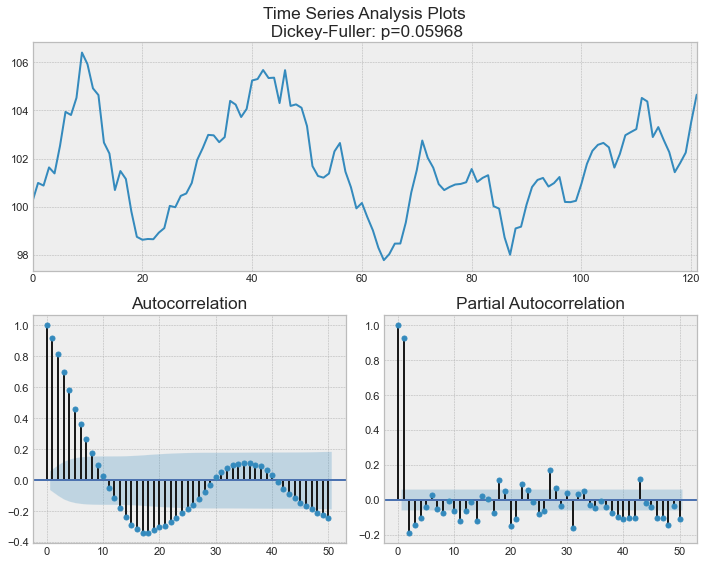

In [67]:
tsplot(df_imports["import_price_index_food&animals"])

### Manufactured Goods Import Price Index

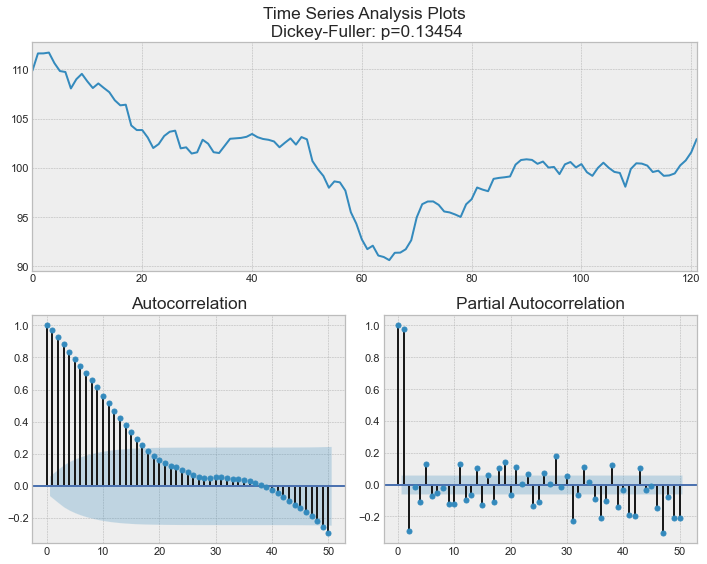

In [69]:
tsplot(df_imports["import_price_index_manufacturedgoods"])

### Machinery Import Price Index

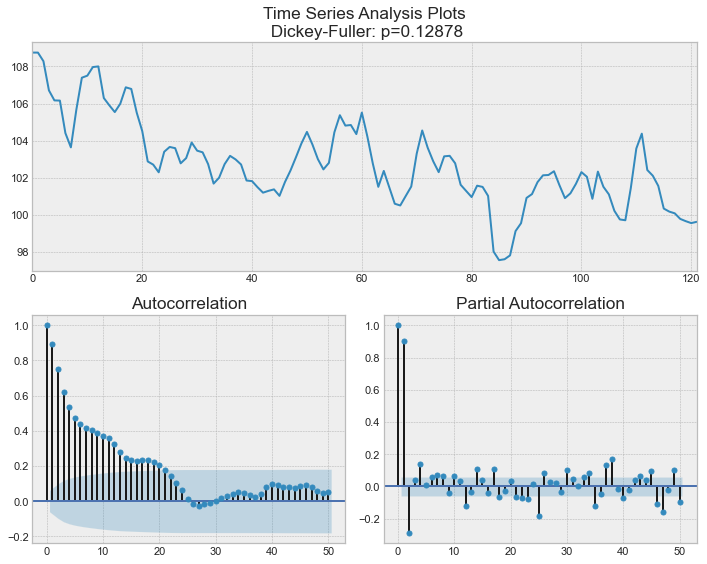

In [70]:
tsplot(df_imports["import_price_index_machinery"])

### Crude Materials Import Price Index

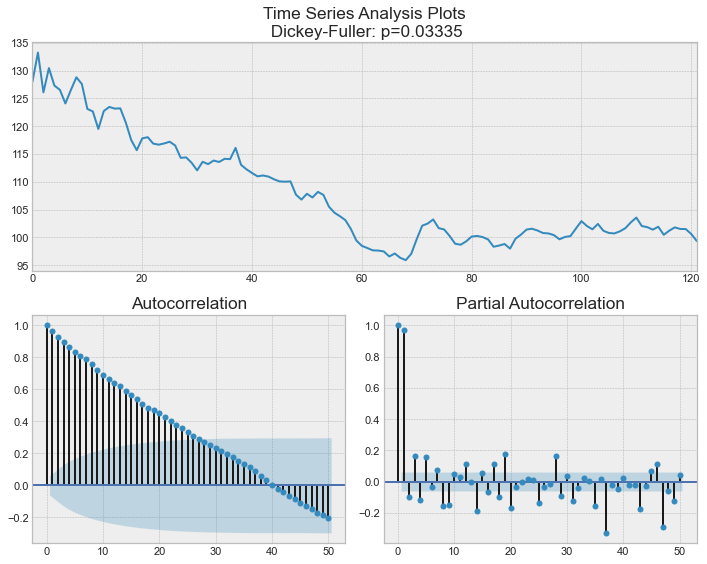

In [72]:
tsplot(df_imports["import_price_index_crudematerials"])

## After Log Transformation


In [73]:
focused_columns = ['neer', 'import_price_index_food&animals','import_price_index_manufacturedgoods','import_price_index_machinery', 'import_price_index_crudematerials']
for column in focused_columns:
    if column in df_imports.columns.values.tolist():
        df_imports[column] = np.log(df_imports[column]+1) 

### Food & Animals Import Price Index (Log)

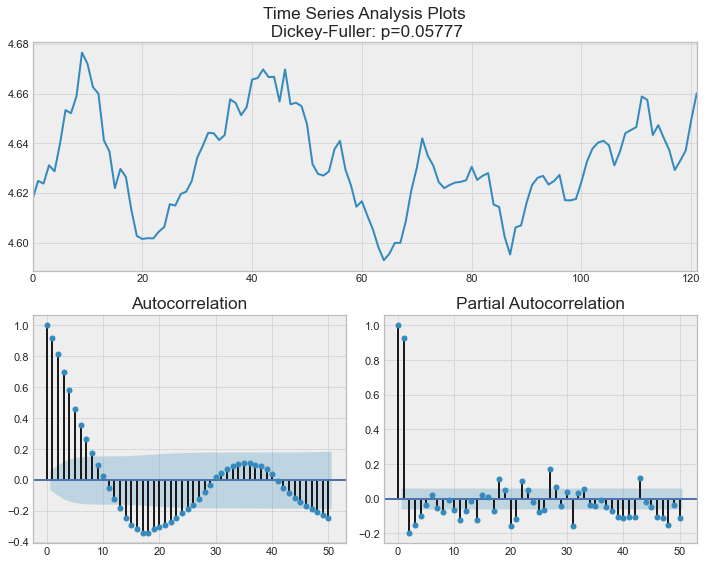

In [74]:
tsplot(df_imports["import_price_index_food&animals"])

### Manufactured Goods Import Price Index (Log)

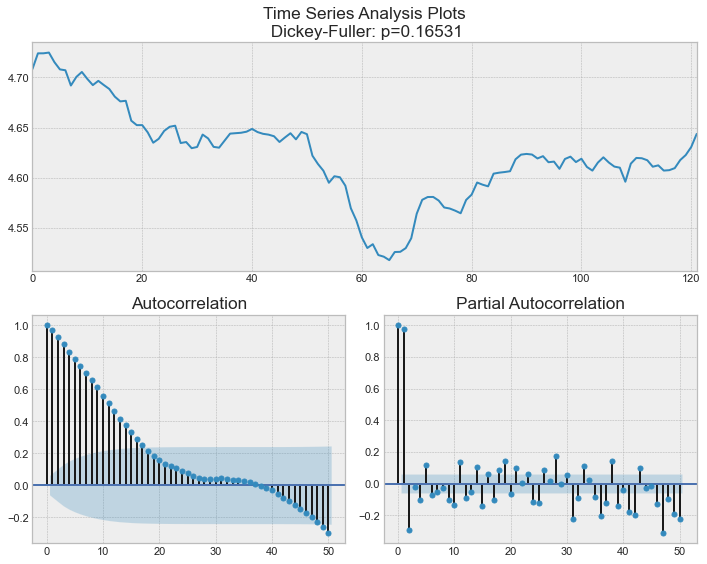

In [75]:
tsplot(df_imports["import_price_index_manufacturedgoods"])

### Machinery Import Price Index (Log)

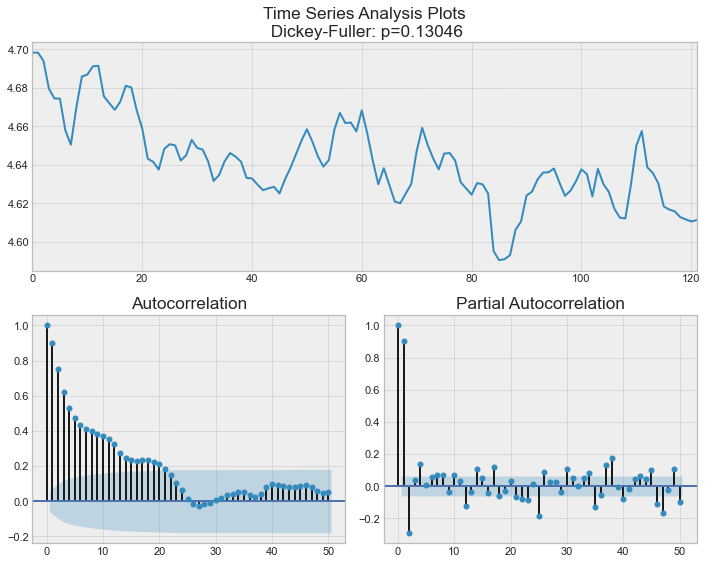

In [76]:
tsplot(df_imports["import_price_index_machinery"])

### Crude Materials Import Price Index (Log)

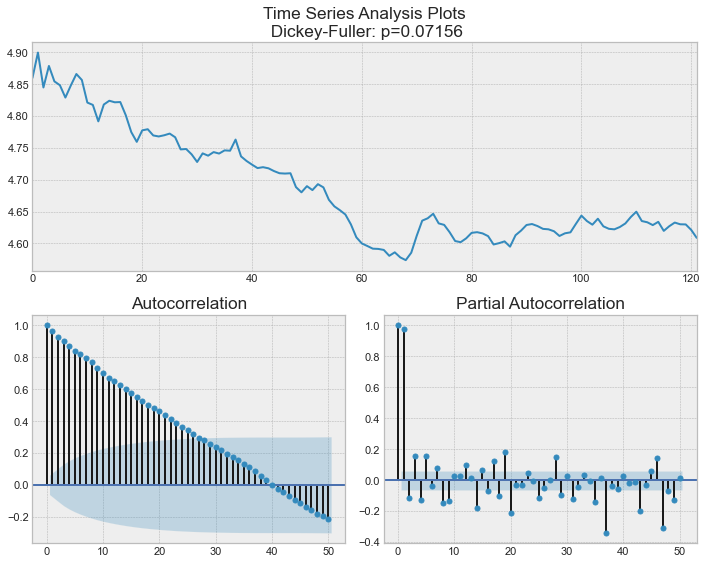

In [77]:
tsplot(df_imports["import_price_index_crudematerials"])

## After Differencing

In [78]:
focused_columns_diff = ['neer', 'import_price_index_food&animals','import_price_index_manufacturedgoods','import_price_index_machinery', 'import_price_index_crudematerials']

for column in focused_columns:
    if column in df_imports.columns.values.tolist():
        df_imports[column] = df_imports[column].diff().dropna()

In [79]:
df_imports = df_imports.dropna()

In [80]:
df_imports.head()

,date,neer,import_price_index_food&animals,import_price_index_manufacturedgoods,import_price_index_machinery,import_price_index_crudematerials
1,2021-02-11,0.002636,0.007371,0.015633,-0.000009,0.039805
2,2021-03-11,0.000475,-0.001069,0.000027,-0.004237,-0.054771
3,2021-04-11,0.007588,0.007364,0.000737,-0.014517,0.033774
4,2021-05-11,0.004288,-0.002429,-0.009556,-0.005035,-0.024219
5,2021-06-11,0.003085,0.011121,-0.007228,-0.000103,-0.006012


### Food & Animals Import Price Index (Log + Diff)

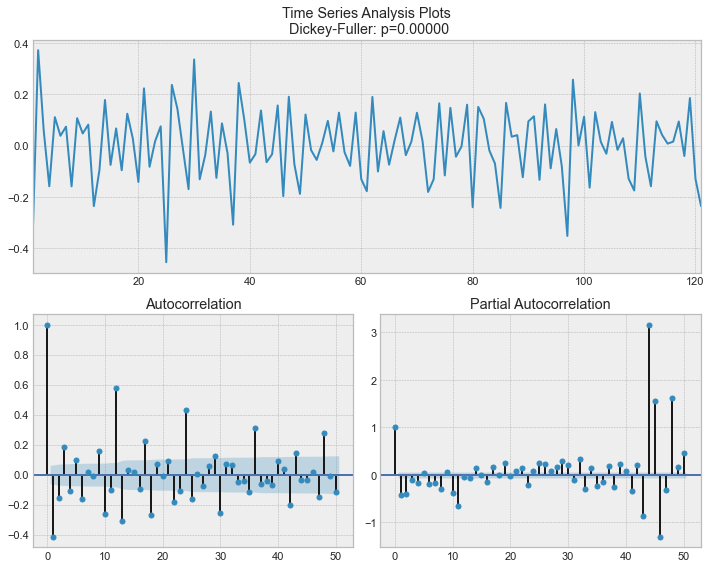

In [38]:
tsplot(df_imports["import_price_index_food&animals"])

### Manufactured Goods Import Price Index (Log + Diff)

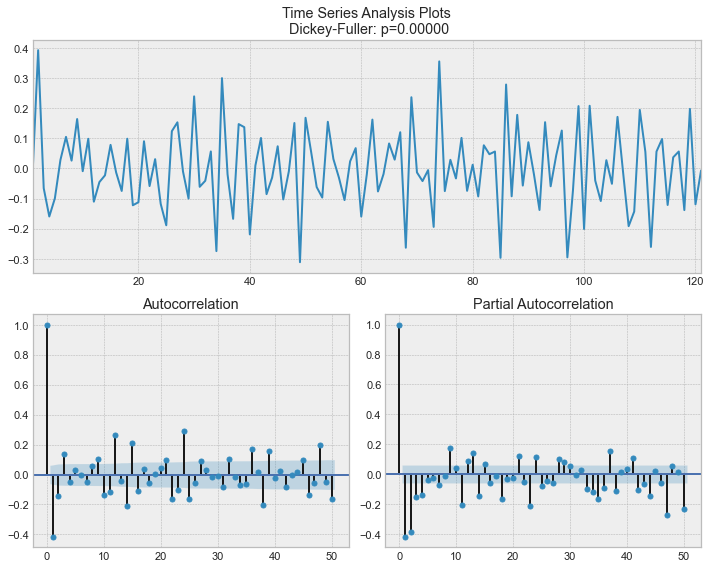

In [39]:
tsplot(df_imports["import_price_index_manufacturedgoods"])

### Machinery Import Price Index (Log + Diff)

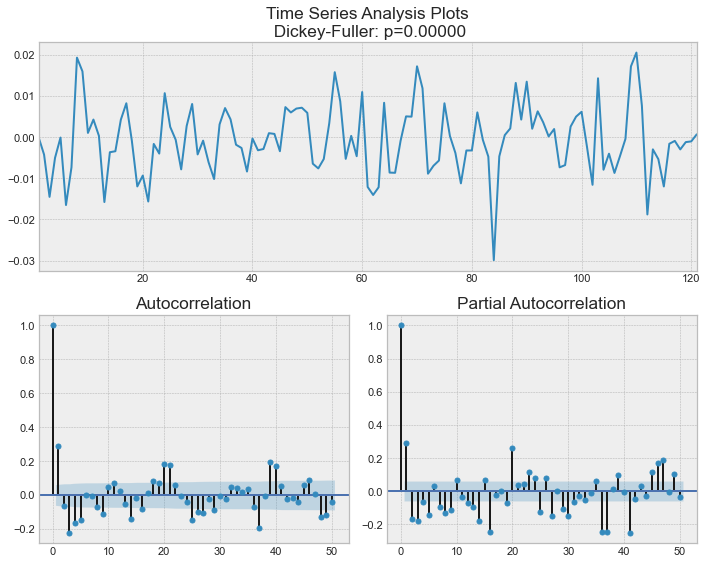

In [81]:
tsplot(df_imports["import_price_index_machinery"])

### Crude Materials Import Price Index (Log + Diff)

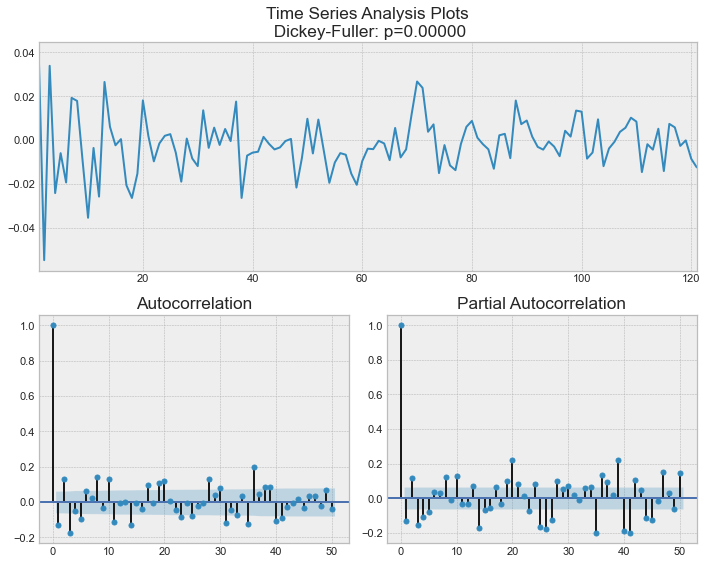

In [82]:
tsplot(df_imports["import_price_index_crudematerials"])

## VAR Model Set Up (Heterogeneous Analysis)

In [83]:
model = VAR(df_imports[focused_columns])
print(model.select_order(10).summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -50.19     -50.07*   1.592e-22     -50.14*
1      -50.32*      -49.58  1.408e-22*      -50.02
2       -50.06      -48.71   1.829e-22      -49.51
3       -50.05      -48.10   1.849e-22      -49.26
4       -49.97      -47.41   2.026e-22      -48.93
5       -49.81      -46.64   2.435e-22      -48.52
6       -49.56      -45.78   3.219e-22      -48.03
7       -49.44      -45.05   3.810e-22      -47.66
8       -49.17      -44.16   5.328e-22      -47.14
9       -49.27      -43.66   5.206e-22      -46.99
10      -49.25      -43.02   5.946e-22      -46.72
--------------------------------------------------


In [84]:
orders = [1]
for o in orders:
    print(f'Order: {o}')
    results = model.fit(o)
    print(results.is_stable())
    print(results.test_whiteness())
    print()


Order: 1
True
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: fail to reject at 5% significance level. Test statistic: 225.747, critical value: 260.992>, p-value: 0.473>



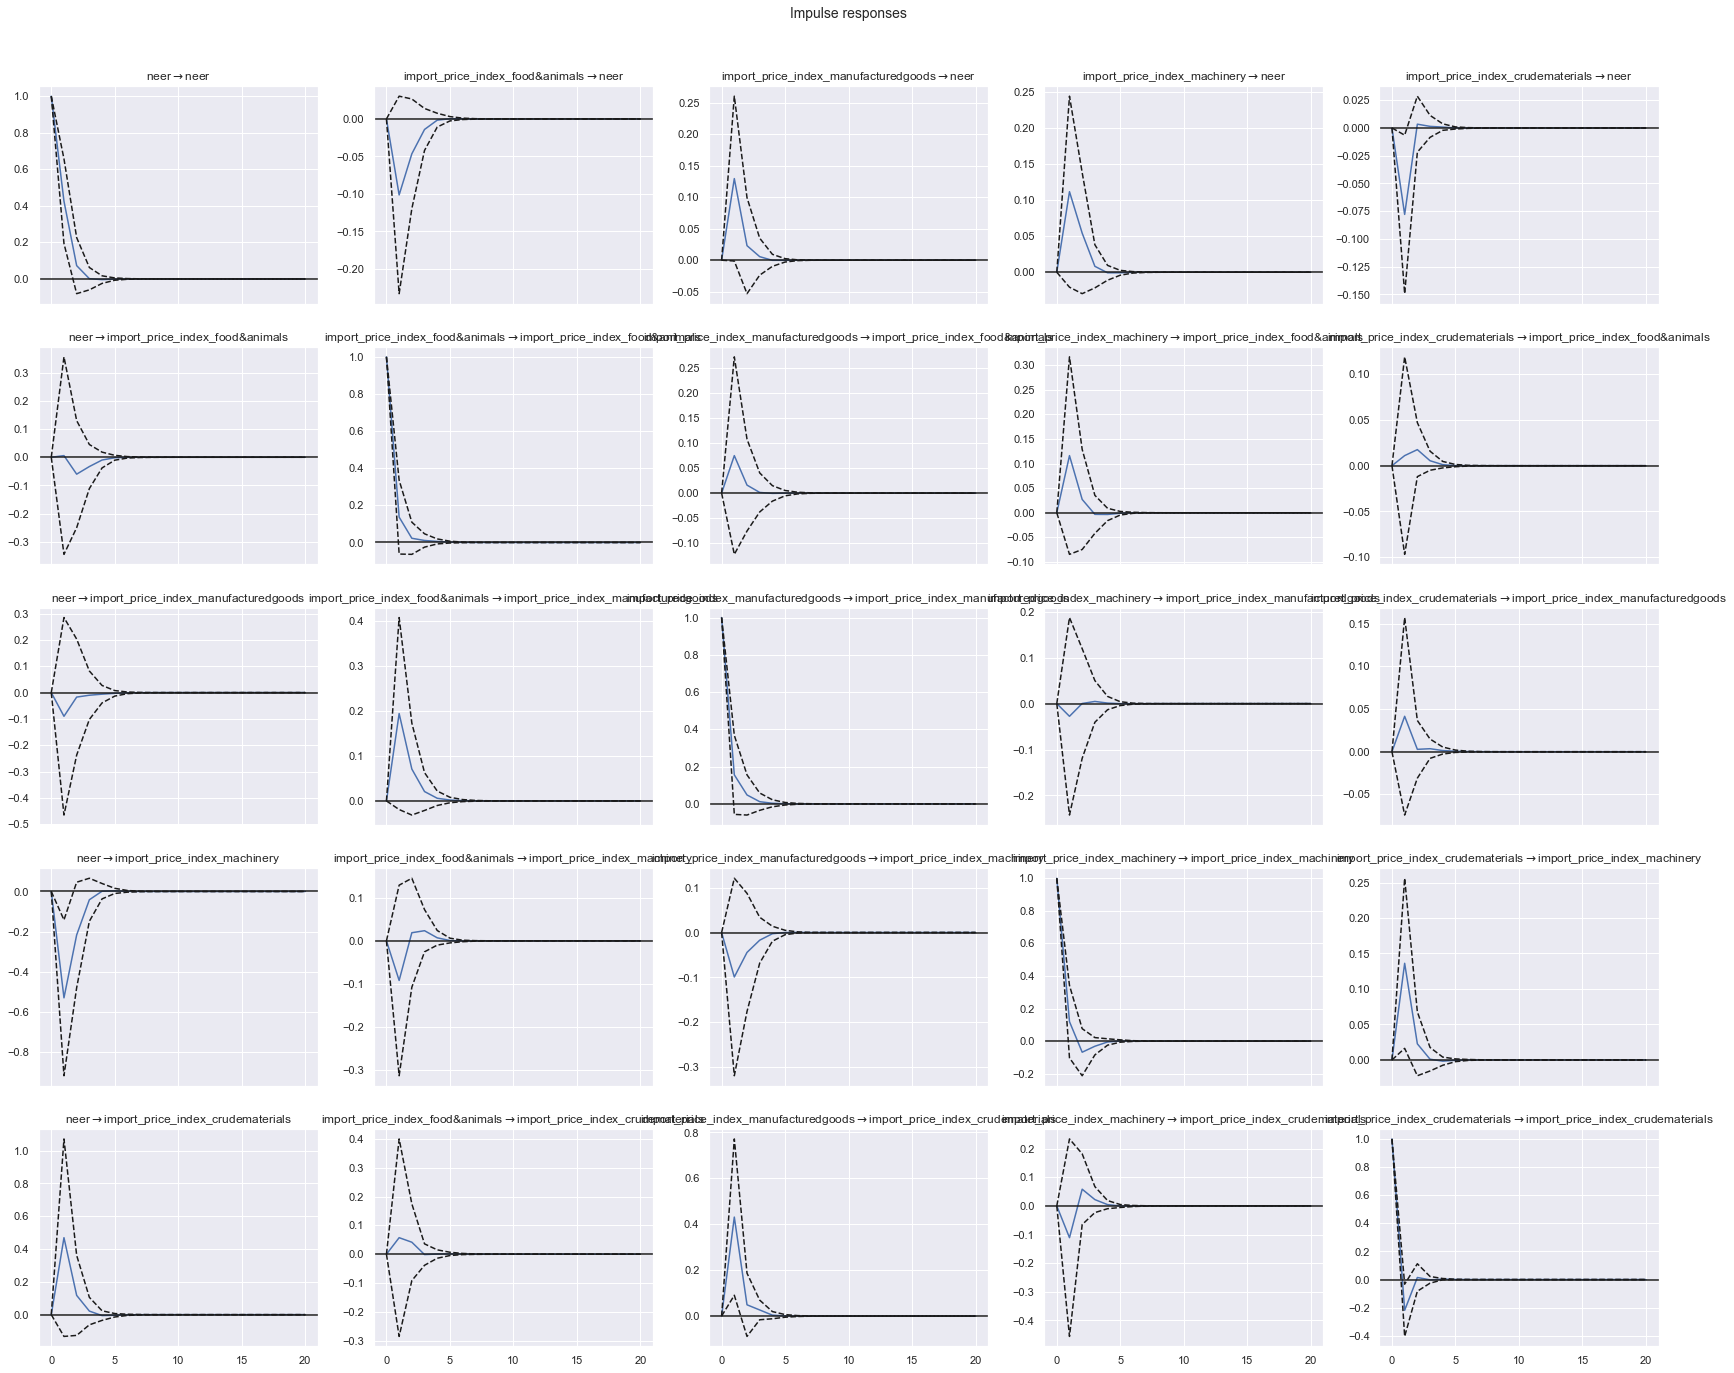

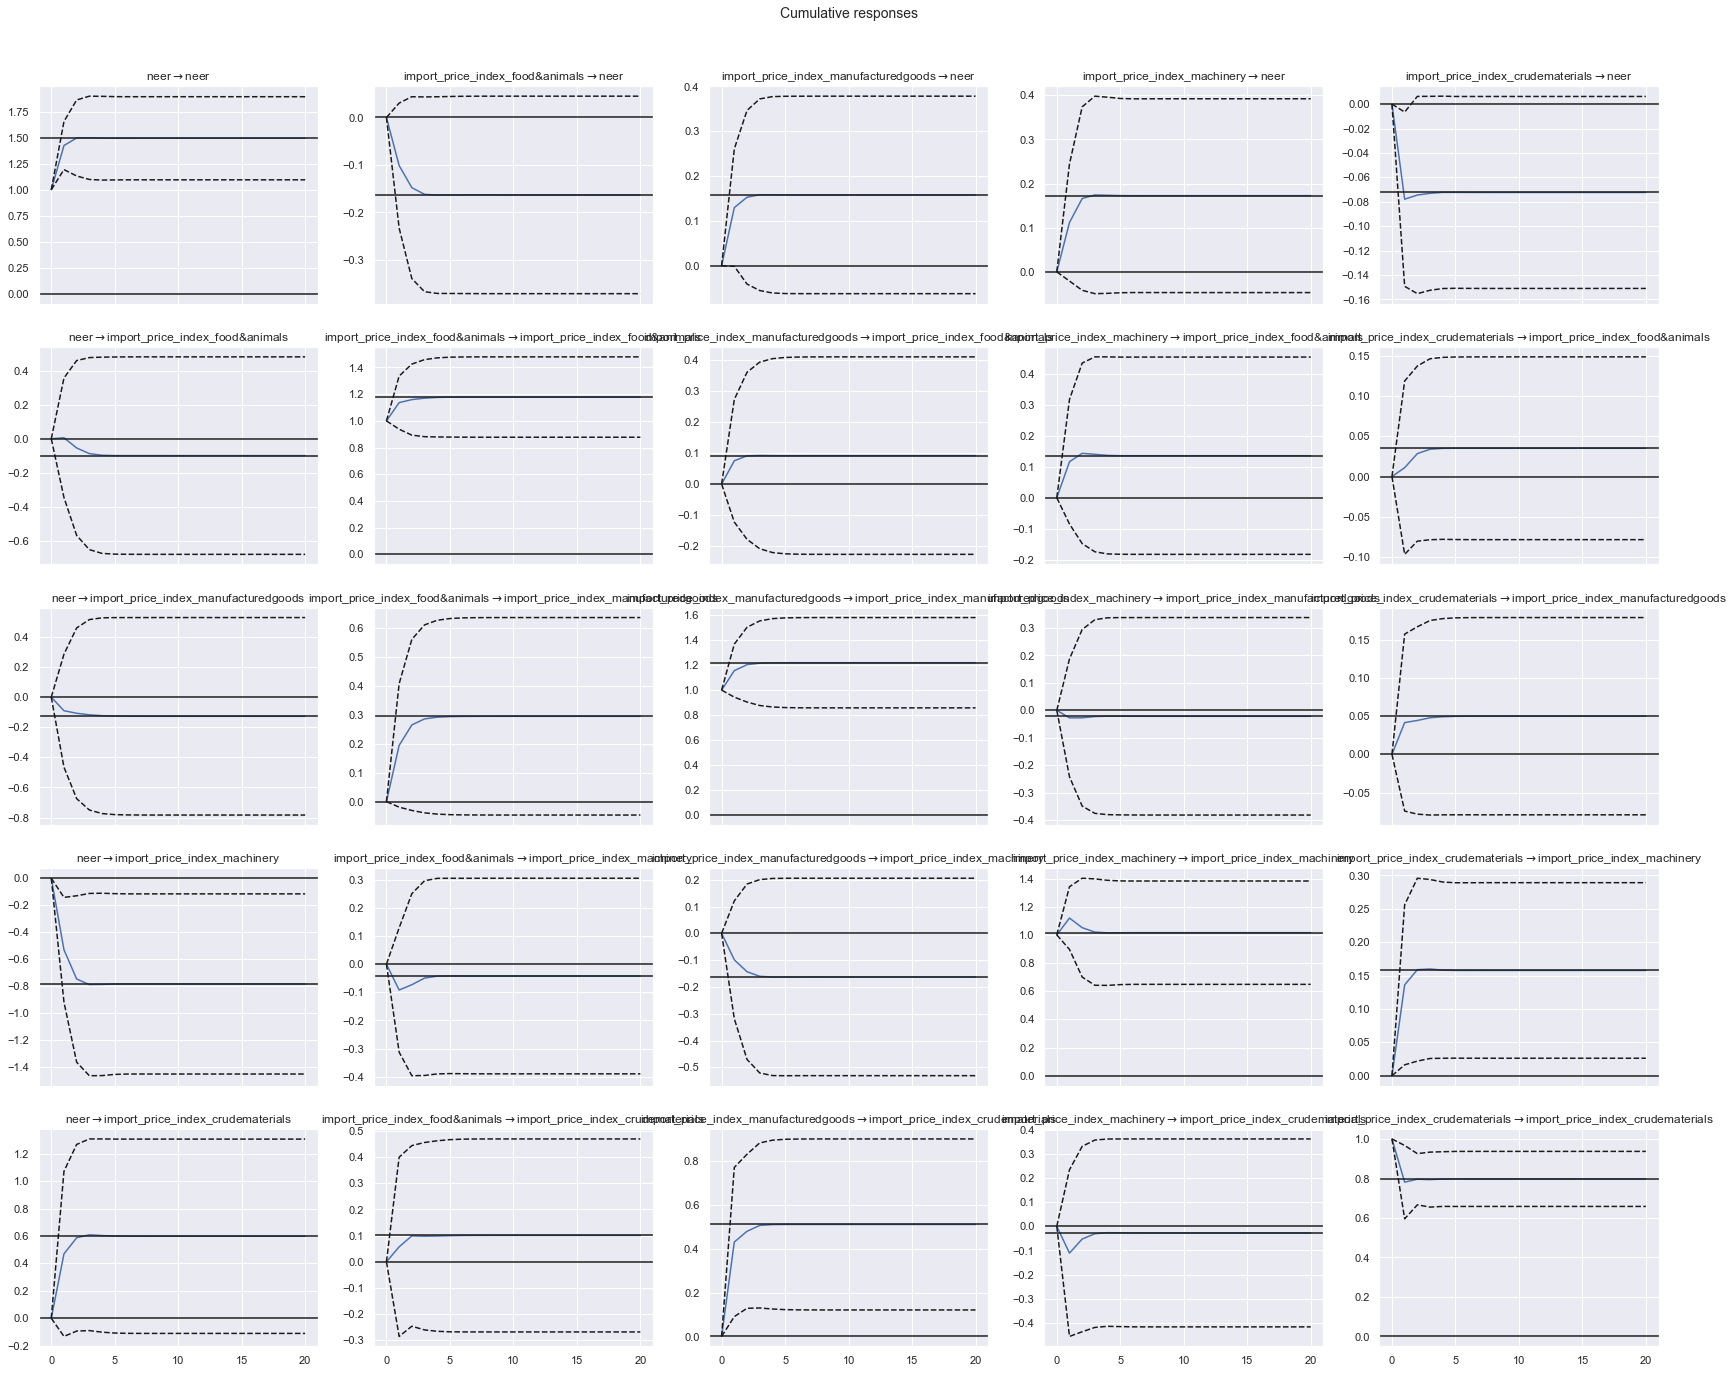

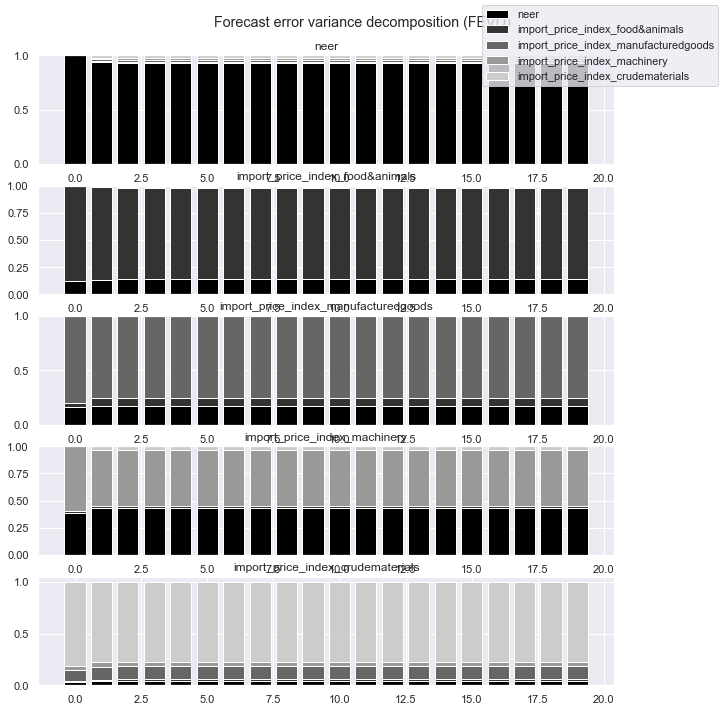

In [85]:
selected_order = 1
results = model.fit(selected_order,trend="c")
results_file = 'results_imports_lag'+str(selected_order)+'.txt'
structual_file = 'imports_lag'+str(selected_order)
columns = df_imports[focused_columns].columns.values.tolist()
write_results(results_file, results, columns)
structural_analyses(structual_file, results, 20)